# Setup PPDisk Simple Model
* CREDIT: RADMC-3D EXAMPLES
* MODELING TARGET: HD163296

## 00 - About ***radmc3dPy.models.ppdisk module***

Generic protoplanetary disk model<br>
The density is given by

* $\rho = \frac{\Sigma(r,\phi)}{H_p\sqrt{(2\pi)}}\exp{(-\frac{z^2}{2H_p^2})}$

    * $\Sigma$ - Surface density
    * $H_p$ - Pressure scale height

There are two options for the functional form of surface density as a function of radius. For a simple power-law the surface density is given by

* $\Sigma(r)=\Sigma_0 (\frac{r}{r_{out}})^p$

alternatively the surface density can also have an exponential outer tapering:

* $\Sigma(r)=\Sigma_0 (\frac{r}{r_{out}})^p \exp[-(\frac{r}{r_{out}})^{2-p}]$

The molecular abundance function takes into account dissociation and <b>freeze-out of the molecules For photodissociation only the continuum (dust) shielding is taken into account in a way that whenever the continuum optical depth radially drops below a threshold value the molecular abundance is dropped to zero.</b> For freeze-out the molecular abundance below a threshold temperature is decreased by a given fractor.

## 00 - About *HD163296*

### Information:
* RA DEC (FK5): 17h53m20.6063742757s -21d56m57.379723676s
* Star Class: Herbig Ae/Be star
* Spectral Type: A1Vep C
* Star Mass: 2.3 $M_{\odot}$
* Star Radius: 1.66 $R_{\odot}$
* Star Temperature: 9330 K
* Distance to us: 140. pc
* Inclination Angle: $42^{\circ}$
* Position Angle: $132^{\circ}$
* Disk Radius: 250. unit:AU
* Gap Position: 60., 100., 160. unit:AU

### Reference:
* *Rosenfeld et al.(2013)*
* *Isella et al. (2016)*
* *Gregorio-Monsalvo et al. (2013)*
* http://simbad.u-strasbg.fr/simbad/sim-id?Ident=HD+163296
* http://www.exoplanetkyoto.org/exohtml/HD_163296.html
* https://sites.uni.edu/morgans/astro/course/Notes/section2/spectraltemps.html

## 01 - Set Up

In [2]:
import numpy as np
from radmc3dPy import *
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt

## 02 - Functions

* All functions are calculated in **CYLINDRICAL** Coordinate

### (1) Calculate Dust/Gas Temperature

In [3]:
def cal_zq(cr):
    '''
    calculate height of disk atmosphere
    '''
    zq0 = 63*natconst.au
    zq = zq0 * (cr/(200*natconst.au))**1.3 * np.exp(-(cr/(800*natconst.au))**2)
    return zq

def cal_delta(cr):
    '''
    calculate vertical shape control parameter
    '''
    delta = 0.0034 * (cr/natconst.au-200) + 2.5
    if delta <= 0.3:
        delta = 0.3
    return delta

def cal_Ta(cr, z):
    '''
    calculate atmosphere temperature
    '''
    #Ta = 55. * (((r**2 + zr**2)**0.5) / (200*natconst.au)) ** (-0.5)
    Ta = 68. * (((cr**2 + z**2)**0.5) / (100*natconst.au)) ** (-0.6)
    return Ta

def cal_Tm(cr):
    '''
    calculate midplane temperature (z=0)
    '''
    #Tm = 19. * (r/(155*natconst.au)) ** (-0.3)
    Tm = 24. * (cr/(100*natconst.au)) ** (-0.5)
    return Tm

def cal_Tgas(cr, z):
    '''
    calculate gas temperature dist.
    '''
    Ta = cal_Ta(cr, z)
    Tm = cal_Tm(cr)
    zq = cal_zq(cr)
    delta = cal_delta(cr)
    if zq > z:
        Tgas = Ta + (Tm - Ta) * np.cos(np.pi/2 * (z/zq)) ** (2*delta)
    else:
        Tgas = Ta
    return Tgas

# These Two functions need to be vectorized for multi-D if statement
cal_delta = np.vectorize(cal_delta)
cal_Tgas = np.vectorize(cal_Tgas)

### (2) Calculate Dust Column Density

In [4]:
def cal_H(cr):
    '''
    calculate disk scale height
    '''
    H = (16. * (cr/(150.*natconst.au))**1.35) * natconst.au
    return H

def cal_dsigma(cr, gamma):
    '''
    calculate dust column density
    with taper term
    '''
    rc = 90.*natconst.au
    cden0 = 0.42 #g/cm2
    cden = cden0 * ((cr/rc)**(-gamma)) * np.exp(-((cr/rc)**(2-gamma)))
    return cden

def cal_ddens(cr, z, gamma):
    '''
    calculate dust density
    from sigmad with taper term
    '''
    H = cal_H(cr)
    cden = cal_dsigma(cr, gamma)
    den = cden / ((2*np.pi)**0.5 * H) * np.exp(-z**2/(2*H**2))
    return den

### (3) Calculate Molecule Number Density

In [5]:
def cal_gsigma(cr, cden0, rc, gamma):
    '''
    calculate column density
    with taper term
    '''
    cden = cden0 * ((cr/rc)**(-gamma)) * np.exp(-((cr/rc)**(2-gamma)))
    return cden

def cal_gdens(cr, z, cden, gamma):
    '''
    calculate dust density
    from sigmad with taper term
    with known dust column density
    '''
    H = cal_H(cr)
    den = cden / ((2*np.pi)**0.5 * H) * np.exp(-z**2/(2*H**2))
    return den

def cal_ndens(density, mol_w):
    ndens = density / (mol_w*natconst.mp)
    return ndens

def cal_depletion(n_molecule, T, Tfrz):
    '''
    calculate 12CO depletion factor
    with CO depletion
    '''
    frz =  0.
    if T <= Tfrz:
        n_molecule = frz * n_molecule
    return n_molecule
cal_depletion = np.vectorize(cal_depletion)

### (4) Make Ring Gaps and Calculate Density

In [6]:
def make_ring_gap(rc, density, Gpc, wid, dep):
    for i, gp in enumerate(Gpc):
        density[abs(rc-gp) < wid[i]/2] /= dep[i]
    return density

def cal_ddens_wi_cden(cr, z, cden, gamma):
    '''
    calculate dust density
    from sigmad with taper term
    with known dust column density
    '''
    H = cal_H(cr)
    den = cden / ((2*np.pi)**0.5 * H) * np.exp(-z**2/(2*H**2))
    return den

## 03 - Parameters


### (1) Common Parameters

In [7]:
# Monte Carlo parameters
nphot    = 1000000

# Star parameters
mstar    = 2.3 * natconst.ms
rstar    = 1.66 * natconst.rs
tstar    = 9330.
pstar    = np.array([0.,0.,0.])

# Grid parameters
nr       = 250
ntheta   = 10
nphi     = 1
rin      = 2 * natconst.au
rout     = 252 * natconst.au
thetaup  = np.arccos(cal_H(rout)/rout)    # Unit: Radian     
#print('Open Theta Angle is {:.10f} radian'.format(np.pi/2-thetaup))

# Ring Gap parameters
Gpc  = [60.*natconst.au, 100.*natconst.au, 160.*natconst.au]
# Widest Gap parameters
Wwid = [33.*natconst.au, 26.*natconst.au, 55.*natconst.au] 
Wddep = [13., 7., 3.6]
WCOdep = [1., 3.5, 1.8]
# Narrowest Gap parameters
Nwid = [15.*natconst.au, 12.*natconst.au, 15.*natconst.au] 
Nddep = [150., 70., 6.]
NCOdep = [2.5, 70., 6.]

In [8]:
# Wavelength Information
lam1     = 0.1e0
lam2     = 7.0e0
lam3     = 25.0e0
lam4     = 1.0e4
n12      = 20
n23      = 100
n34      = 30
lam12    = np.logspace(np.log10(lam1),np.log10(lam2),n12,endpoint=False)
lam23    = np.logspace(np.log10(lam2),np.log10(lam3),n23,endpoint=False)
lam34    = np.logspace(np.log10(lam3),np.log10(lam4),n34,endpoint=True)
lam      = np.concatenate([lam12,lam23,lam34])
nlam     = lam.size

### (2) Dust Parameters

In [9]:
dgamma   = 0.1
dRc      = 90 * natconst.au
dcdenc   = 0.42

### (3) Molecule Gas Parameters

In [10]:
ggamma    = 0.8
gRc       = 165 * natconst.au
cdenc12CO = 1.6e-3 
cdenc13CO = 2.3e-5
cdencC18O = 2.9e-6
CO_H2     = 5e-5 * 28/2 # Abundance

## 04 - Calculate Input Data

### (1) Make Input Grids

In [11]:
# Make the coordinates
ri       = np.linspace(rin, rout, nr+1)
thetai   = np.linspace(thetaup, 0.5e0*np.pi, ntheta+1)
phii     = np.linspace(0.0e0, np.pi*2.e0, nphi+1)
rc       = 0.5 * (ri[0:nr] + ri[1:nr+1])
thetac   = 0.5 * (thetai[0:ntheta] + thetai[1:ntheta+1])
phic     = 0.5 * (phii[0:nphi] + phii[1:nphi+1])

# Make the grid
qq       = np.meshgrid(rc,thetac,phic,indexing='ij')
rr       = qq[0]
tt       = qq[1]
zr       = np.pi/2.e0 - qq[1]

### (2) Calculate Temperature
* Here assuming all gas and dust are in Equilibrium, then Tgas=Tdust

In [12]:
from copy import deepcopy
# Make the gas temperature model
Tgas = cal_Tgas(rr, zr)
Dgas = deepcopy(Tgas)

### (3) Calculate Dust Density

In [13]:
# Calculate Column Density, Then make Gaps
dsigmas = cal_dsigma(rr*np.cos(zr), dgamma)
dsigma  = make_ring_gap(rr*np.cos(zr), dsigmas, Gpc=Gpc, wid=Wwid, dep=Wddep)

# Calculate Dust Density
ddens = cal_ddens_wi_cden(rr*np.cos(zr), rr*np.sin(zr), dsigma, dgamma)

### (4) Calculate Molecule Gas Number Density
* Assuming there is Only CO, H2
* Assuming [CO]/[H2] is universal constant

In [14]:
# 12CO Molecule Gas
gsigma12COs = cal_gsigma(rr*np.cos(zr), cdenc12CO, gRc, ggamma)
gsigma12CO  = make_ring_gap(rr*np.cos(zr), gsigma12COs, Gpc=Gpc, wid=Wwid, dep=WCOdep)
gdens12CO   = cal_gdens(rr*np.cos(zr), rr*np.sin(zr), gsigma12CO, ggamma)
n12CO = cal_ndens(gdens12CO, 28)
n12CO = cal_depletion(n12CO, Tgas, 19.)

# All Gas
gsigma = gsigma12CO / CO_H2
gdens  = gdens12CO  / CO_H2
n12CO  = cal_ndens(gdens, 2.3)

### (5) Calculate Molecule Gas Velocity
* Assuming Keplerian Motions
* Here also writing velocity inp file
* Systematic Velocity is got from Observational Spectral Profile

In [15]:
vpm = np.zeros((nr, ntheta, nphi))
with open('gas_velocity.inp','w+') as f:
    f.write('1\n')                        # Format number
    f.write('%d\n' % (nr*ntheta*nphi))    # Nr of cells
    for i in range(nphi):
        for j in range(ntheta):
            for k in range(nr):
                r = (ri[k] + ri[k+1]) / 2
                t = np.pi/2 - (thetai[j] + thetai[j]) / 2
                z = r * np.sin(t)
                vpm[k, j, i] = -(natconst.gg*mstar)**0.5 * r/((r**2 + z**2)**0.75)
                vr, vt, vp = 0.0, 0.0, -(natconst.gg*mstar)**0.5 * r/((r**2 + z**2)**0.75)
                f.write('{:.6e}\t{:.6e}\t{:.6e}\t\n'.format(vr, vt, vp))
np.save('gas_velocity', vpm)

## 05 - Write Inp files

### (1) Wavelength

In [16]:
# Write the wavelength file
with open('wavelength_micron.inp','w+') as f:
    f.write('%d\n'%(nlam))
    for value in lam:
        f.write('%13.6e\n'%(value))

### (2) Star (Radiation Source)

In [17]:
# Write the stars.inp file
with open('stars.inp','w+') as f:
    f.write('2\n')
    f.write('1 %d\n\n'%(nlam))
    f.write('%13.6e %13.6e %13.6e %13.6e %13.6e\n\n'%(rstar,mstar,pstar[0],pstar[1],pstar[2]))
    for value in lam:
        f.write('%13.6e\n'%(value))
    f.write('\n%13.6e\n'%(-tstar))

### (3) AMR Grid (Meshgrid Point Table for Radmc3d)

In [18]:
# Write the grid file
with open('amr_grid.inp','w+') as f:
    f.write('1\n')                       # iformat
    f.write('0\n')                       # AMR grid style  (0=regular grid, no AMR)
    f.write('100\n')                     # Coordinate system: spherical
    f.write('0\n')                       # gridinfo
    f.write('1 1 0\n')                   # Include r,theta coordinates
    f.write('%d %d %d\n'%(nr,ntheta,1))  # Size of grid
    for value in ri:
        f.write('%13.6e\n'%(value))      # X coordinates (cell walls)
    for value in thetai:
        f.write('%13.6e\n'%(value))      # Y coordinates (cell walls)
    for value in phii:
        f.write('%13.6e\n'%(value))      # Z coordinates (cell walls)

### (4) Temperature

In [19]:
# Write the temperature file
with open('dust_temperature.dat','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    f.write('1\n')
    data = Tgas.ravel(order='F')         # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

with open('gas_temperature.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    data = Tgas.ravel(order='F')         # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

### (5) Dust Density

In [20]:
# Write the dust density file
with open('dust_density.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    f.write('1\n')                       # Nr of dust species
    data = ddens.ravel(order='F')        # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

### (6) Dust Opacity (Control File for Dust Opacity)

* Originally, we use silicate opacity in RADMC3D
* However, HD163296 is in much denser region
* Therefore, new opacity profile is needed

In [22]:
# New dust kappa (opacity)
with open('dustkappa_silicate.inp', 'w+') as out:
    data = open('dustkappa_silicate-backup.inp', 'r').readlines()[2:]
    out.write('2\n240\n')
    factor = 36.
    for i in range(len(data)):
        if float(data[i].split()[0]) > 1e1:
            row = data[i].split()
            row[1] = '{:.6e}'.format(float(row[1])*factor)
            row[2] = '{:.6e}'.format(float(row[2])*factor)
            out.write('\t'.join(row) + '\n')

In [23]:
# Dust opacity control file
with open('dustopac.inp','w+') as f:
    f.write('2               Format number of this file\n')
    f.write('1               Nr of dust species\n')
    f.write('============================================================================\n')
    f.write('1               Way in which this dust species is read\n')
    f.write('0               0=Thermal grain\n')
    f.write('silicate        Extension of name of dustkappa_***.inp file\n')
    f.write('----------------------------------------------------------------------------\n')

### (7) Molecule Gas Number Density

In [24]:
with open('numberdens_co.inp','w+') as f:
    f.write('1\n')                         # Format number
    f.write('%d\n'%(nr*ntheta*nphi))       # Nr of cells
    data = n12CO.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

### (8) Gas Velocity Turbulence

In [25]:
vturb0  = 0.0 #3.0e5
vturb   = np.zeros((nr,ntheta,nphi)) + vturb0

# Write the microturbulence file
with open('microturbulence.inp','w+') as f:
    f.write('1\n')                         # Format number
    f.write('%d\n'%(nr*ntheta*nphi))       # Nr of cells
    data = vturb.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

### (9) Line Mode Inp
* Only Let **lins.inp** file exist when calculating line emission
* It must be deleted when calculating dust continuum

In [26]:
# Write the lines.inp control file
with open('lines.inp','w+') as f:
    f.write('1\n')
    f.write('1\n')
    f.write('co    leiden    0    0\n')
    
def Line_Mode(Switch):
    Switch = bool(Switch)
    if Switch:
        with open('lines.inp','w+') as f:
            f.write('1\n')
            f.write('1\n')
            f.write('co    leiden    0    0\n')
    else:
        # Close Line Mode
        from os import system
        from os.path import isfile
        if isfile('lines.inp'):
            system('rm lines.inp')

### (10) Radmc3D Input (Control File for Monte Carlo Simulation)

In [27]:
# Write the radmc3d.inp control file
with open('radmc3d.inp','w+') as f:
    f.write('nphot = %d\n'%(nphot))
    f.write('scattering_mode_max = 1\n')
    f.write('modified_random_walk = 1\n')  # Put this to 1 for random walk
    f.write('tgas_eq_tdust = 0\n')         # Put this to 1 for Tgas=Tdust
    f.write('iranfreqmode = 1\n')

## 06 - Basic Analysis

### (1) Column Density, Density, Dust/Gas Ratio

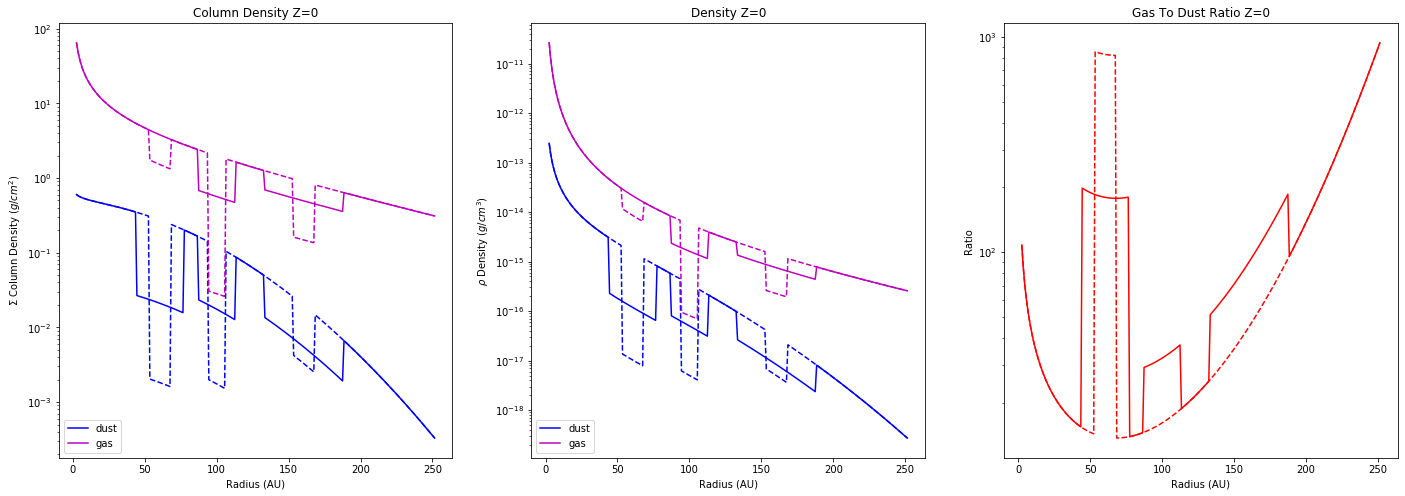

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

dsigmas = cal_dsigma(rr*np.cos(zr), dgamma)
dsigma  = make_ring_gap(rr*np.cos(zr), dsigmas, Gpc=Gpc, wid=Wwid, dep=Wddep)
ddens = cal_ddens_wi_cden(rr*np.cos(zr), rr*np.sin(zr), dsigma, dgamma)
axes[0].semilogy(rr[:,0,0]/natconst.au, dsigma[:,-1,0], 'b', label='dust')
axes[1].semilogy(rr[:,0,0]/natconst.au, ddens[:,-1,0], 'b', label='dust')

dsigmas = cal_dsigma(rr*np.cos(zr), dgamma)
dsigma  = make_ring_gap(rr*np.cos(zr), dsigmas, Gpc=Gpc, wid=Nwid, dep=Nddep)
ddens = cal_ddens_wi_cden(rr*np.cos(zr), rr*np.sin(zr), dsigma, dgamma)
axes[0].semilogy(rr[:,0,0]/natconst.au, dsigma[:,-1,0], 'b--')
axes[1].semilogy(rr[:,0,0]/natconst.au, ddens[:,-1,0], 'b--')

gsigma12COs = cal_gsigma(rr*np.cos(zr), cdenc12CO, gRc, ggamma)
gsigma12CO  = make_ring_gap(rr*np.cos(zr), gsigma12COs, Gpc=Gpc, wid=Wwid, dep=WCOdep)
gdens12CO   = cal_gdens(rr*np.cos(zr), rr*np.sin(zr), gsigma12CO, ggamma)
gsigma = gsigma12CO / CO_H2
gdens  = gdens12CO  / CO_H2
axes[0].semilogy(rr[:,0,0]/natconst.au, gsigma[:,-1,0], 'm', label='gas')
axes[1].semilogy(rr[:,0,0]/natconst.au, gdens[:,-1,0], 'm', label='gas')

gsigma12COs = cal_gsigma(rr*np.cos(zr), cdenc12CO, gRc, ggamma)
gsigma12CO  = make_ring_gap(rr*np.cos(zr), gsigma12COs, Gpc=Gpc, wid=Nwid, dep=NCOdep)
gdens12CO   = cal_gdens(rr*np.cos(zr), rr*np.sin(zr), gsigma12CO, ggamma)
gsigma = gsigma12CO / CO_H2
gdens  = gdens12CO  / CO_H2
axes[0].semilogy(rr[:,0,0]/natconst.au, gsigma[:,-1,0], 'm--')
axes[1].semilogy(rr[:,0,0]/natconst.au, gdens[:,-1,0], 'm--')

dsigmas = cal_dsigma(rr*np.cos(zr), dgamma)
dsigma  = make_ring_gap(rr*np.cos(zr), dsigmas, Gpc=Gpc, wid=Wwid, dep=Wddep)
ddens = cal_ddens_wi_cden(rr*np.cos(zr), rr*np.sin(zr), dsigma, dgamma)
gsigma12COs = cal_gsigma(rr*np.cos(zr), cdenc12CO, gRc, ggamma)
gsigma12CO  = make_ring_gap(rr*np.cos(zr), gsigma12COs, Gpc=Gpc, wid=Wwid, dep=WCOdep)
gdens12CO   = cal_gdens(rr*np.cos(zr), rr*np.sin(zr), gsigma12CO, ggamma)
gsigma = gsigma12CO / CO_H2
gdens  = gdens12CO  / CO_H2
axes[2].semilogy(rr[:,0,0]/natconst.au, gdens[:,-1,0]/ddens[:,-1,0], 'r')

dsigmas = cal_dsigma(rr*np.cos(zr), dgamma)
dsigma  = make_ring_gap(rr*np.cos(zr), dsigmas, Gpc=Gpc, wid=Nwid, dep=Nddep)
ddens = cal_ddens_wi_cden(rr*np.cos(zr), rr*np.sin(zr), dsigma, dgamma)
gsigma12COs = cal_gsigma(rr*np.cos(zr), cdenc12CO, gRc, ggamma)
gsigma12CO  = make_ring_gap(rr*np.cos(zr), gsigma12COs, Gpc=Gpc, wid=Nwid, dep=NCOdep)
gdens12CO   = cal_gdens(rr*np.cos(zr), rr*np.sin(zr), gsigma12CO, ggamma)
gsigma = gsigma12CO / CO_H2
gdens  = gdens12CO  / CO_H2
axes[2].semilogy(rr[:,0,0]/natconst.au, gdens[:,-1,0]/ddens[:,-1,0], 'r--')

axes[0].set_title('Column Density Z=0')
axes[0].set_xlabel(r'Radius (AU)')
axes[0].set_ylabel(r'$\Sigma$ Column Density ($g/cm^2$)')
axes[0].legend(loc=3)
axes[1].set_title('Density Z=0')
axes[1].set_xlabel(r'Radius (AU)')
axes[1].set_ylabel(r'$\rho$ Density ($g/cm^3$)')
axes[1].legend(loc=3)
axes[2].set_title('Gas To Dust Ratio Z=0')
axes[2].set_xlabel(r'Radius (AU)')
axes[2].set_ylabel(r'Ratio')

plt.show()

### (2) Dust Density, Temperature Profile

In [29]:
# Setup Boundary
R, THETA_max = rr[:,0,0], zr[0,0,0]
# Set up model in Cylindrical System
nr, nph, nz = nr, nphi, 100 #ntheta
Ri       = np.linspace(rin, rout, nr+1)
Phii     = np.linspace(0.0e0, np.pi*2.e0, nph+1)
Zi       = np.linspace(0.0e0, R[-1]*THETA_max, nz+1)
Rc       = 0.5 * (Ri[0:nr] + Ri[1:nr+1])
Phic     = 0.5 * (Phii[0:nph] + Phii[1:nph+1])
Zic      = 0.5 * (Zi[0:nz] + Zi[1:nz+1])
QQ       = np.meshgrid(Rc,Phic,Zic,indexing='ij')
RR       = QQ[0]
TT       = QQ[1]
ZZ       = QQ[2]

In [30]:
# Calculate Column Density and Density, Then make Gaps
SIGMADS = cal_dsigma(RR, dgamma)
SIGMA = make_ring_gap(RR, SIGMADS, Gpc=Gpc, wid=Wwid, dep=Wddep)
# Calculate Dust Density
DDENS = cal_ddens_wi_cden(RR, ZZ, SIGMADS, dgamma)
TOMO_D = DDENS[:,0,:].T
TOMO_D[TOMO_D < 1e-20] = 1e-22
# Calculate Dust Temperature
TGAS = cal_Tgas(RR, ZZ)
TOMO_T = TGAS[:,0,:].T

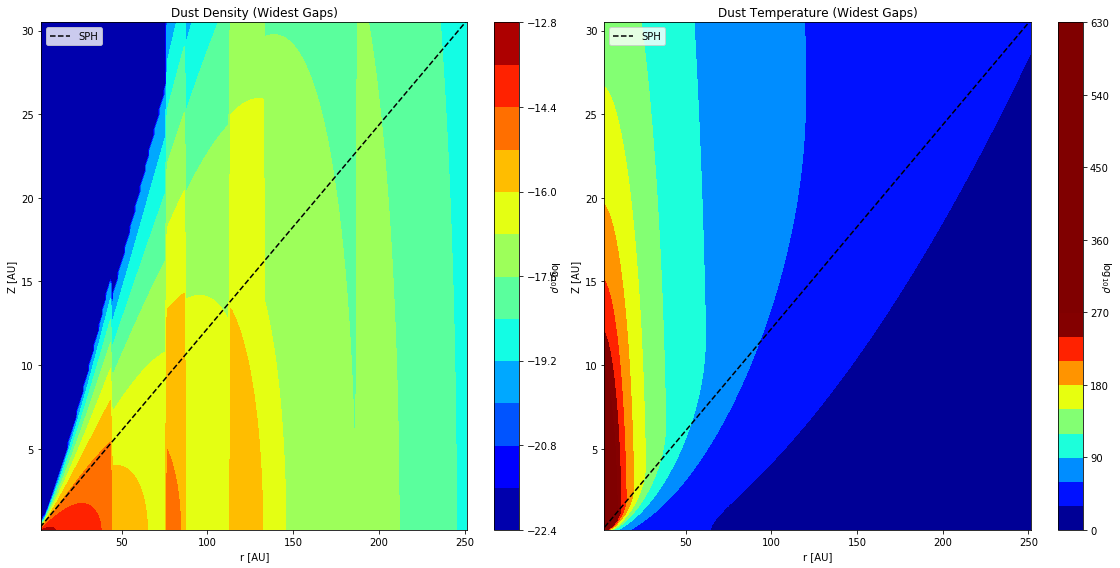

In [31]:
# Plot Dust Density and Temperature
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.plot(R/natconst.au, R*THETA_max/natconst.au, 'k--', label='SPH')
c  = plt.contourf(RR[:,0,0]/natconst.au, ZZ[0,0,:]/natconst.au, np.log10(TOMO_D), 10, cmap='jet')
cb = plt.colorbar(c)
cb.set_label(r'$\log_{10}{\rho}$', rotation=270.)
plt.xlim(3, max(R/natconst.au))
plt.ylim(min(ZZ[0,0,:]/natconst.au), max(ZZ[0,0,:]/natconst.au))
plt.title('Dust Density (Widest Gaps)')
plt.xlabel('r [AU]')
plt.ylabel('Z [AU]')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(R/natconst.au, R*THETA_max/natconst.au, 'k--', label='SPH')
c  = plt.contourf(RR[:,0,0]/natconst.au, ZZ[0,0,:]/natconst.au, TOMO_T, 20, cmap='jet')
cb = plt.colorbar(c)
plt.clim(10, 256)
cb.set_label(r'$\log_{10}{\rho}$', rotation=270.)
plt.ylim(min(ZZ[0,0,:]/natconst.au), max(ZZ[0,0,:]/natconst.au))
plt.title('Dust Temperature (Widest Gaps)')
plt.xlabel('r [AU]')
plt.ylabel('Z [AU]')
plt.tight_layout()
plt.legend()

plt.show()